# Linear programming for Water Distribution Systems - Optimization project (1/2)

**Objectives:**
- Implement a linear programming solution for the optimization of a water distribution system 

**Completition requirements:**

By the end of this notebook, you should have:
- Implemented all the code cells for:
  - Defining the optimization problem
  - Solving the optimization problem
  - Analyzing the found solution
- Answered all the questions

This notebook based on paper: Linear Programming Analysis of a Water Supply System, by Ishwar Gupta (1969)

## 📔 Libraries

<!-- 
# If you have not installed pytorch geometric uncomment the following lines to install it

# !pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# !pip install wntr -->

To run this notebook you need to have installed the following packages:
- Numpy
- Matplotlib
- Gurobi

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import gurobipy as gp

## 🔙 Background

A water distribution system transports water from sources, like wells or reservoirs, to various locations where water is needed, like homes, shops, and factories. 

A basic system consists of sources of water supply and demand points for water connected by pipe lines. Figure 1 shows a typical system where there are two supply centers and ten demand nodes. A transmission system that connects sparse populations can be considered as a simple network of one reservoir and few nodes and pipes. For the sake of simplicity, we illustrate the optimization algorithms with such system as example. Nevertheless, in a city of moderate size, there may be a number of supply centers and hundreds of demand points. 

<div>
<center><img src="./Images/WDSAsset 1v1.png" width="400"/></center>
</div>

<!-- ![WDSAsset 1v1.png](<attachment:WDSAsset 1v1.png>) -->

Figure 1. Simplified scheme of a branched water distribution system.
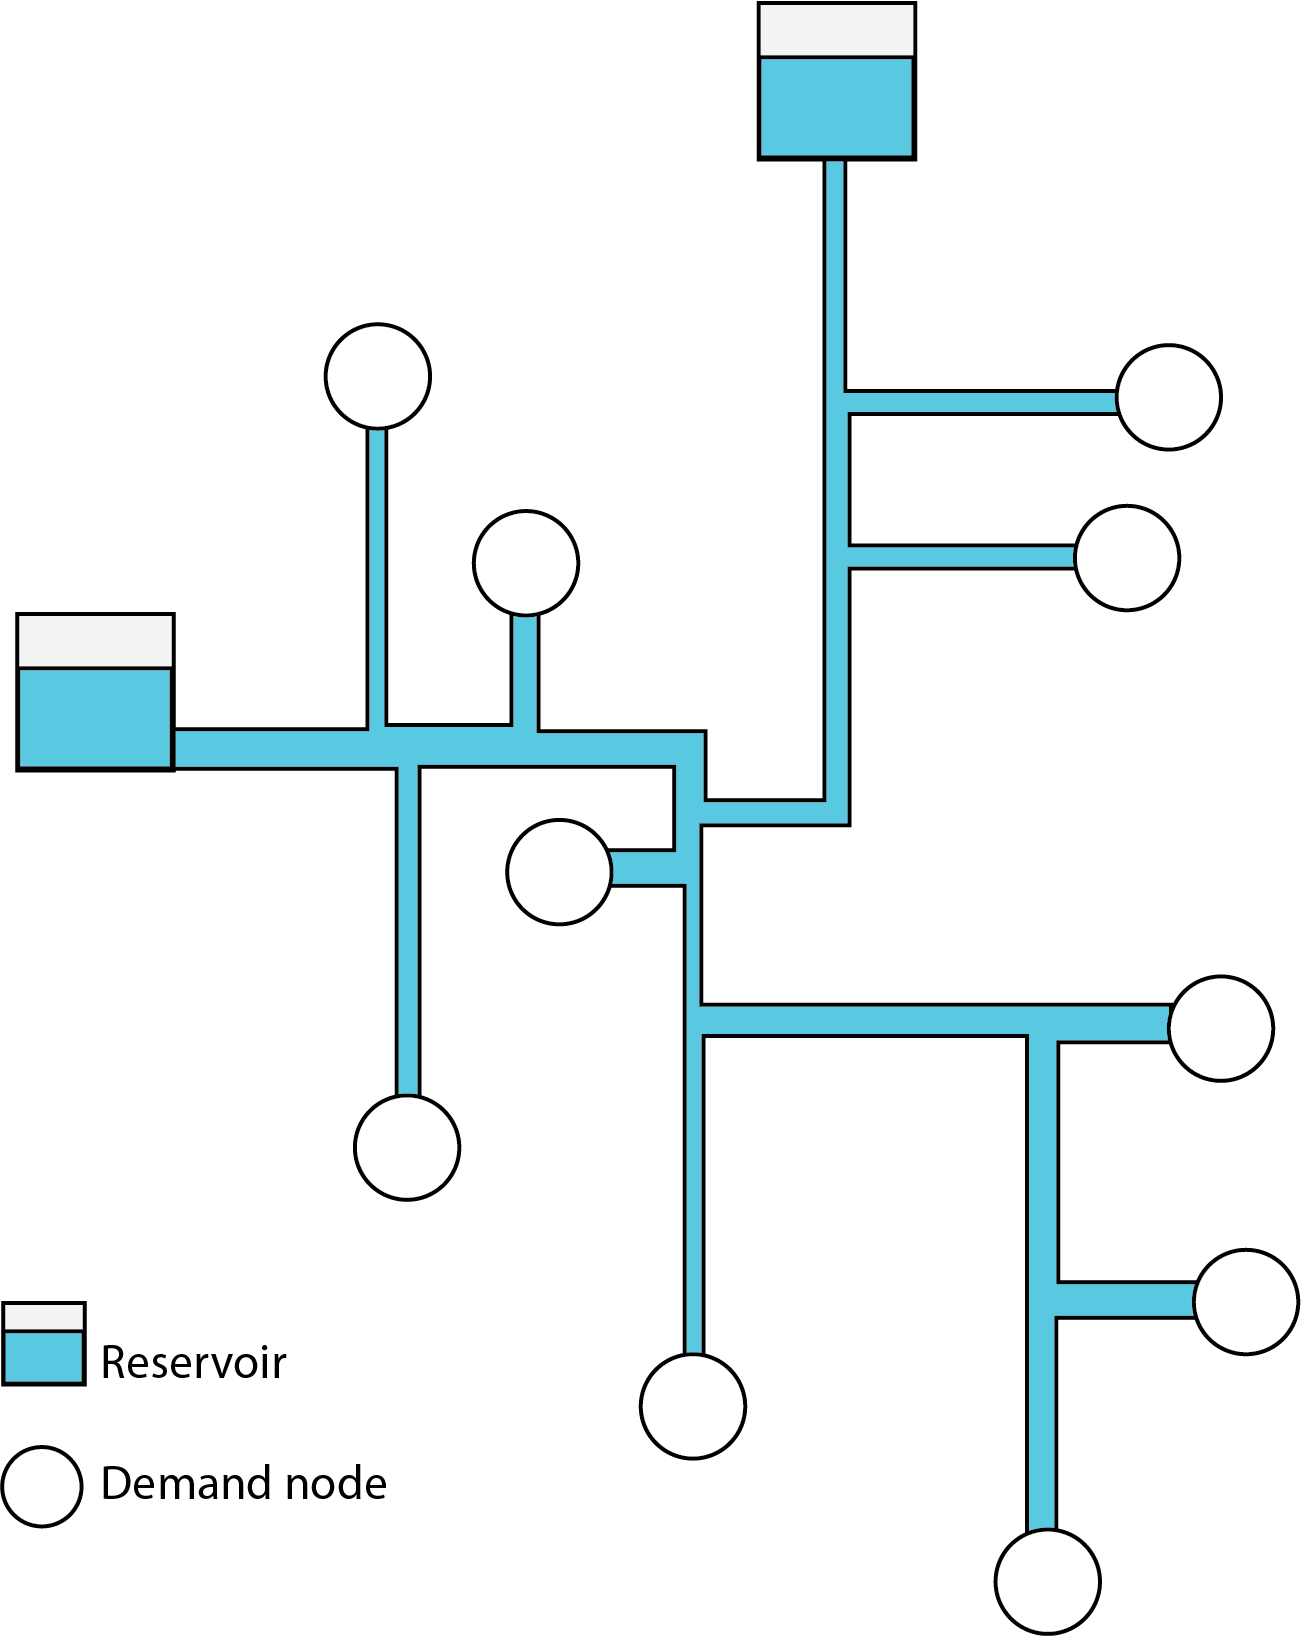

#### Hydraulic head
In water distribution systems, hydraulic head is a fundamental concept. It represents the energy status of water at a specific point within the system. It is defined as the sum of the elevation head (potential energy due to height above a reference point), the pressure head (energy due to fluid pressure), and the velocity head (energy due to fluid velocity) (usually neglected).

Engineers use hydraulic head calculations to ensure proper water pressure, efficient flow, and reliable distribution of water to consumers.

The hydraulic head $(H)$ can be approximated as the sum of two components: elevation head ($z$)) and pressure head $(P)$:

$$
\begin{align}
H = z + \frac{P}{\rho g}
\end{align}
$$

Where:
- $(z)$= Elevation above a reference point (meters or feet)
- $(P)$= Pressure in the fluid (Pascals or pounds per square inch)
- $(\rho)$ = Density of the fluid (kg/m³ or lb/ft³)
- $(g)$= Acceleration due to gravity (9.81 m/s² or 32.2 ft/s²)

Notice that the units of this variable are meters.

## ⛔ Problem definition 

The problem is to find the pipe lenghts and diameters that minimize the cost of the pipe lines while satisfying the customer demand for water usage and supply pressure. 

To solve this problem, we can consider that the pipe lines can be composed of multiple segments. Each segment has one of the available diameters. In that case, a water distribution system with M pipes and N possible diameters will have $ M \cdot N $ decision variables. 
 
If we consider only two posibilities for diameters, one pipe line can be divided in two sections of lengths $L_{1}$ and $L_{2}$. If any of the lenghts is equal to the total length, that means that the pipe has only one diameter.

We can frame this problem in an optimization setting. To do so, we need to define the objective function and the restrictions. 

### 🎯 Objective function

We want to minimize the cost of the pipes. Each pipe has a different cost according to its diameter and its length. Generally, the larger the pipe, the more expensive it is. 

We can define the total cost $Z$ of installing all the pipes as the following function
$$
\begin{align}
  & min Z = \sum_{j=1}^{N}C_{j}\sum_{i=1}^{M} L_{ij}\\
\end{align}
$$ (eq_cost_function)

where $C_{j}$ is the cost of pipe per meter-length having diameter $j$.

### 🚫 Restrictions

We consider two main restrictions.

1) The water should arrive at the consumer nodes with sufficient pressure. This is, there should be sufficient energy for transporting the water from the source to each of nodes. This restriction can be written as

$$
\sum_{j=1}^{N}\sum_{i=1}^{M}S_{ijk} \cdot L_{ijk} \leq H_{k} \; \text{for every path k between the reservoir and a consumer node.}
$$

where $S$ is the slope of head loss. It refers to the gradual reduction in hydraulic head (energy) along the length of a pipe or conduit due to factors such as friction, bends, fittings, and other resistance-inducing elements. In essence, it represents the rate of energy loss as water flows through the system. This slope can be estimated assuming that a flow of water $Q$ is being transported by pipes of diameter $D$ and roughness coefficient $C$. 
$$
\begin{align}

S = \frac{10.67}{C^{1.852}} \cdot \frac{Q^{1.852}}{D^{4.8704}}

\end{align}
$$

This equation is known as the Hazen-Williams equation. Notice that this equation does not depend on the length of the pipes; therefore, these coefficients are fixed for certain diameter and flow.

2) The sum of all the sections in a pipe must be the total length of each pipe.

$$
\sum_{j=1}^{N}L_{ij} = L_{i} \; \text{  for each pipe  } i = 1, 2,..., M
$$


In addition, we consider that all lengths and heights are larger or equal than zero.
$$
L_{ij}\geq 0 \; \text{  for each segment} \; j \;\text{of each pipe  } i = 1, 2,..., M
$$
$$

## 💻 Linear Programming - Example

We exemplify the solution for a simple case shown in figure 2. This system consists of a reservoir located 180 meters above the consumption node, and it only has one pipe line of length $L$ = 3 km that delivers the water to a consumption node which demands a flow $q$ of 1.5 $m^{3}/s$. In addition, the water company should guarantee that the pressure at the consumption node is at least 20 meters.

The available diameters and their cost-per-meter are given in the following table: 
| Diameter | Cost per meter [€/m]|
|----------|----------------|
| 0.3| 4.0|
| 0.4| 2.0|


<div>
<center><img src="./Images/WDSAsset 4v1.png" width="1200"/></center>
</div>

Figure 2. Simple water distribution system of one reservoir, one demand node, and one pipe comprised of two subsections.

First, let's define some preliminary functions and variables that are going to be used later.

In [1]:
def calculate_S(flow, diameter):
    # This function calculates the head loss per unit length of a steel pipe (roughness coefficient C = 100) in SI units.
    # Input: flow in cubic meters per second, diameter in meters.
    
    return (10.67/(100**1.852)) * (flow**1.852)/(diameter**4.8704)

In [17]:
total_length = 200
available_energy = 180-20
available_diameters = np.array([0.3, 0.4])

coefficients_s = calculate_S(flow = 1.5, diameter=available_diameters)
coefficients_cost = np.array([2, 4])

Next, we can create a model in Gurobi. 

In [18]:
#Initialize a Gurobi model
model = gp.Model()

#Create decision variables
lengths = model.addVars(len(available_diameters), name="lengths")

#Set minimization objective
model.setObjective(gp.quicksum(coefficients_cost[i] * lengths[i] for i in range(len(lengths))), gp.GRB.MINIMIZE)

#Add constraints
# The energy losses should be less or equal than the available energy
model.addConstr(gp.quicksum(coefficients_s[i] * lengths[i] for i in range(len(lengths))) <= available_energy)

#Length
# The total length of the pipe should be the sum of its sub-sections.
model.addConstr(gp.quicksum(lengths[i] for i in range(len(lengths)))==total_length)

#All the lenghts must the equal or greater than zero.
for i in range(len(lengths)):
    model.addConstr(lengths[i] >= 0)


model.update()


Let's verify that the model is correct by printing model (this is only practical for small models).

In [19]:
print(model.display())

Minimize
  2.0 lengths[0] + 4.0 lengths[1]
Subject To
  R0: 1.5736714732390413 lengths[0] + 0.3876255981684169 lengths[1] <= 160
  R1: lengths[0] + lengths[1] = 200
  R2: lengths[0] >= 0
  R3: lengths[1] >= 0
None


Now, we can optimize the model.

In [20]:
model.optimize()

Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-8665U CPU @ 1.90GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 4 rows, 2 columns and 6 nonzeros
Model fingerprint: 0xbc5f9569
Coefficient statistics:
  Matrix range     [4e-01, 2e+00]
  Objective range  [2e+00, 4e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+02, 2e+02]
Presolve removed 4 rows and 2 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.6092464e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective  6.609246369e+02


We can explore what lengths producted the optimal cost:

In [21]:
optimal_lengths = model.x
optimal_cost = model.objVal

print(optimal_lengths)
print(optimal_cost)

[69.5376815516563, 130.4623184483437]
660.9246368966874


Since this example deals with two decision variables, we can plot the restrictions and the solution in a 2D plane as follows:

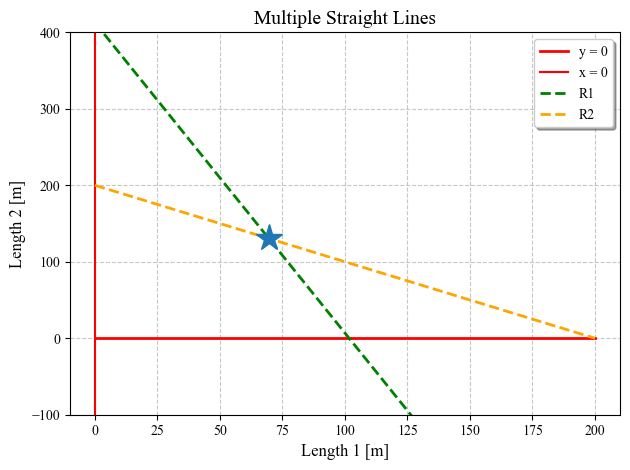

In [22]:
# Generate some data points for the lines
length_1 = np.linspace(0, total_length, 100)

#The axis represent the restriction of having positive lenghts.
x_axis = np.zeros_like(length_1)
y_axis = np.zeros_like(length_1)

#Restriction 1: The length 
length_2_restr_1 = (available_energy - coefficients_s[0] * length_1) / coefficients_s[1]
length_2_restr_2 = total_length - length_1

# Set the default font to Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the lines with different line styles and colors
ax.plot(length_1, x_axis, label='y = 0', color='red', linestyle='-', linewidth=2)
ax.axvline(x=y_axis[0], color='red', linestyle='-', label='x = 0')

ax.plot(length_1, length_2_restr_1, label='R1', color='green', linestyle='--', linewidth=2)
ax.plot(length_1, length_2_restr_2, label='R2', color='orange', linestyle='--', linewidth=2)

plt.plot([optimal_lengths[0]], [optimal_lengths[1]], marker='*', ls='none', ms=20)


# Set labels and title with increased font size
ax.set_xlabel('Length 1 [m]', fontsize=12)
ax.set_ylabel('Length 2 [m]', fontsize=12)
ax.set_title('Multiple Straight Lines', fontsize=14)

# Add a legend with larger font size and shadow
ax.legend(fontsize=10, shadow=True)

# Set grid lines
ax.grid(True, linestyle='--', alpha=0.7)

# Customize tick label font size
ax.tick_params(axis='both', labelsize=10)

ax.set_ylim(-100, 400)

# Show the plot with a tight layout
plt.tight_layout()

# Show the plot
plt.show()



## 💻 Linear Programming - Exercise

Consider the larger network in figure 3. This system consists of a reservoir that supplies to two consumer nodes. 
The reservoir is located at 130 meters above the reference level. The first pipe line connects the reservoir to a diversion node where the network splits in two branches: Pipe lines 2 and 3. 

Pipe line 1 has a length $L_{1}$ of 40 meters, pipe line 2 has a length $L_{2}$ of 10 meters, and pipe line 3 has a length $L_{3}$ of 20 meters. 

Node A demands 3 $m^{3}/s$ and node B demands 2 $m^{3}/s$.

Node A must have a hydraulic head of 30 meters or more, and node B must have a hydraulic head of 30 meters or more.

The available diameters and their cost-per-meter are given in the following table: 
| Diameter | Cost per meter  [€/m]|
|----------|----------------|
| 0.5| 10|
| 1.0| 20|
| 1.5| 30|


<div>
<center><img src="./Images/WDSAsset 6v1.png" width="1000"/></center>
</div>

Figure 3. Branched system with 2 demand nodes. Each of the three pipe lines can be comprised of three different diameters.

**Instructions**
Find the length and diameter of each section for all the pipe lines in the water distribution system that minimizes the cost of installing the system while supplying the required amount of water and pressure.

In the following cell, define the variables for solving this new problem.

Define the relevant variables

In [23]:
total_length_1 = 4000
total_length_2 = 1000
total_length_3 = 2000

flow_1 = 5
flow_2 = 2
flow_3 = 3

min_pressure = 130-30
available_diameters = np.array([0.5, 1.0, 1.5])

coefficients_s_1 = calculate_S(flow = flow_1, diameter=available_diameters)
coefficients_s_2 = calculate_S(flow = flow_2, diameter=available_diameters)
coefficients_s_3 = calculate_S(flow = flow_3, diameter=available_diameters)

coefficients_cost = np.array([10, 20, 30])

In the following cell, define the Gurobi model, including the objective function and restrictions. 

In [13]:
#Initialize a Gurobi model
model = gp.Model()

#Create decision variables
lengths = model.addVars(len(available_diameters)*3, name="lengths")

#Set minimization objective
model.setObjective(gp.quicksum(coefficients_cost[i%3] * lengths[i] for i in range(len(lengths))), gp.GRB.MINIMIZE)

#Add constraints
#Length
model.addConstr(gp.quicksum(lengths[i]for i in [0, 1, 2])==total_length_1)
model.addConstr(gp.quicksum(lengths[i]for i in [3, 4, 5])==total_length_2)
model.addConstr(gp.quicksum(lengths[i]for i in [6, 7, 8])==total_length_3)

for i in range(len(lengths)):
    model.addConstr(lengths[i] >= 0)

#Pressure
model.addConstr(gp.quicksum(coefficients_s_1[i] * lengths[i] for i in [0,1,2]) + gp.quicksum(coefficients_s_2[i%3] * lengths[i] for i in [3,4,5]) <= min_pressure)
model.addConstr(gp.quicksum(coefficients_s_1[i] * lengths[i] for i in [0,1,2]) + gp.quicksum(coefficients_s_2[i%3] * lengths[i] for i in [6,7,8]) <= min_pressure)

model.update()


Print the model to verify its objective function and restrictions

In [14]:
print(model.display())

Minimize
10.0 lengths[0] + 20.0 lengths[1] + 30.0 lengths[2] + 10.0 lengths[3]
+ 20.0 lengths[4] + 30.0 lengths[5] + 10.0 lengths[6] + 20.0 lengths[7] + 30.0 lengths[8]
Subject To
  R0: lengths[0] + lengths[1] + lengths[2] = 4000
  R1: lengths[3] + lengths[4] + lengths[5] = 1000
  R2: lengths[6] + lengths[7] + lengths[8] = 2000
  R3: lengths[0] >= 0
  R4: lengths[1] >= 0
  R5: lengths[2] >= 0
  R6: lengths[3] >= 0
  R7: lengths[4] >= 0
  R8: lengths[5] >= 0
  R9: lengths[6] >= 0
  R10: lengths[7] >= 0
  R11: lengths[8] >= 0
R12: 1.2156074648162658 lengths[0] + 0.04155821326773034 lengths[1] +
0.005767956804539288 lengths[2] + 0.22274525549582397 lengths[3] + 0.007615036185772089
 lengths[4] + 0.001056907800669166 lengths[5] <= 100
R13: 1.2156074648162658 lengths[0] + 0.04155821326773034 lengths[1] +
0.005767956804539288 lengths[2] + 0.22274525549582397 lengths[6] + 0.007615036185772089
 lengths[7] + 0.001056907800669166 lengths[8] <= 100
None


Optimize the model

In [15]:
model.optimize()

Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-8665U CPU @ 1.90GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 14 rows, 9 columns and 30 nonzeros
Model fingerprint: 0xb5683645
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+01, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+02, 4e+03]
Presolve removed 10 rows and 2 columns
Presolve time: 0.01s
Presolved: 4 rows, 7 columns, 14 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.2848433e+05   1.245535e+03   0.000000e+00      0s
       5    1.6240723e+05   0.000000e+00   0.000000e+00      0s

Solved in 5 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.624072286e+05


Print the results

In [16]:
model.x

[0.0,
 1723.8798071691062,
 2276.1201928308938,
 35.397333811095606,
 964.6026661889044,
 0.0,
 0.0,
 2000.0,
 0.0]